In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer,
                             confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost

%matplotlib inline
from sklearn.datasets import load_boston

from sklearn.base import clone
from sklearn import tree

In [94]:
df = pd.read_csv('Loan_Default.csv')

df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [39]:
df.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

In [16]:
df.isna().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [54]:
# existen NA pero se desconoce si esto es correcto o incorrecto ya que no se tiene documentación del Dataset por
#lo que sólo se convertirán las columnas categoricas a númericas
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes
        
# y las variables tipo númericas se completan con promedios
df = df.fillna(df.mean())

In [42]:
#df.describe().T
#df["loan_limit"].unique()

df.shape

(148670, 34)

In [92]:
y = df["Status"]
X = df.drop("Status", axis=1)

In [93]:
X.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,dtir1
0,24890,2019,0,3,0,0,0,0,0,1,...,1740.0,3,758,0,0,1,98.728814,3,1,45.000000
1,24891,2019,0,2,0,1,0,0,0,0,...,4980.0,2,552,1,3,1,72.746457,0,1,37.732932
2,24892,2019,0,2,1,0,0,0,0,1,...,9480.0,3,834,0,1,1,80.019685,3,1,46.000000
3,24893,2019,0,2,0,0,3,0,0,1,...,11880.0,3,587,0,2,0,69.376900,0,1,42.000000
4,24894,2019,0,1,1,0,0,0,0,1,...,10440.0,1,602,1,0,0,91.886544,0,1,39.000000


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Construir modelo

In [57]:
#KNN
knn = KNeighborsRegressor().fit(X_train, y_train)
y_hat_knn = knn.predict(X_test)
y_hat_knn=(y_hat_knn).flatten()

In [58]:
#LinearR
lir = LinearRegression().fit(X_train, y_train)
y_hat_lir = lir.predict(X_test)
y_hat_lir=(y_hat_lir).flatten()

In [59]:
#Lasso
lasso = Lasso().fit(X_train, y_train)
y_hat_lasso = lasso.predict(X_test)
y_hat_lasso=(y_hat_lasso).flatten()

In [60]:
#Ridge
ridge = Ridge().fit(X_train, y_train)
y_hat_ridge = ridge.predict(X_test)
y_hat_ridge=(y_hat_ridge).flatten()

C:\Users\jeramirez\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.00349e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [61]:
#ElasticNet
elasticNet = ElasticNet().fit(X_train, y_train)
y_hat_ElasticNet = elasticNet.predict(X_test)
y_hat_ElasticNet=(y_hat_ElasticNet).flatten()

In [62]:
#LogisticRegression
logisticRegression = LogisticRegression().fit(X_train, y_train)
y_hat_LogisticRegression = ogisticRegression.predict(X_test)
y_hat_LogisticRegression=(y_hat_LogisticRegression).flatten()

NameError: name 'ogisticRegression' is not defined

In [64]:
#DecissionTree
decisionTreeRegressor = DecisionTreeRegressor().fit(X_train, y_train)
y_hat_DecisionTreeRegressor = decisionTreeRegressor.predict(X_test)
y_hat_DecisionTreeRegressor=(y_hat_DecisionTreeRegressor).flatten()

In [65]:
#RandomForest
randomForestRegressor = RandomForestRegressor().fit(X_train, y_train)
y_hat_RandomForestRegressor = randomForestRegressor.predict(X_test)

In [63]:
#XGBoost
xGBRegressor = XGBRegressor().fit(X_train, y_train)
y_hat_XGBRegressor = xGBRegressor.predict(X_test)

In [66]:
df_hats = pd.DataFrame(data=[y_hat_knn,y_hat_lir, y_hat_lasso, y_hat_ridge, y_hat_ElasticNet, y_hat_DecisionTreeRegressor, y_hat_RandomForestRegressor,y_hat_XGBRegressor])

In [67]:
df_hats=df_hats.T

In [68]:
df_hats.columns=['y_hat_knn','y_hat_lir', 'y_hat_lasso', 'y_hat_ridge', 'y_hat_ElasticNet', 'y_hat_DecisionTreeRegressor', 'y_hat_RandomForestRegressor','y_hat_XGBRegressor']

In [69]:
df_hats.head(3)

,y_hat_knn,y_hat_lir,y_hat_lasso,y_hat_ridge,y_hat_ElasticNet,y_hat_DecisionTreeRegressor,y_hat_RandomForestRegressor,y_hat_XGBRegressor
0,0.6,0.271473,0.254293,0.271666,0.254315,0.0,0.0,0.000003
1,0.2,0.314085,0.265203,0.313186,0.265218,0.0,0.0,0.000003
2,0.0,0.343148,0.235136,0.343195,0.235146,0.0,0.0,0.000003


In [70]:
df_results = []
for i in df_hats.columns:
    r2 = r2_score(y_test,df_hats[i])
    df_results.append(r2)
print(df_results)

[0.22424426295882527, 0.12354689681642472, 0.0039709235191855985, 0.12355009603992517, 0.003963540240741081, 1.0, 1.0, 0.9999999998593917]


In [71]:
df_results = pd.DataFrame(data=df_results)
df_results = df_results.T
df_results.columns = ['y_hat_knn','y_hat_lir', 'y_hat_lasso', 'y_hat_ridge', 'y_hat_ElasticNet', 'y_hat_DecisionTreeRegressor', 'y_hat_RandomForestRegressor','y_hat_XGBRegressor']
df_results.head(3)

,y_hat_knn,y_hat_lir,y_hat_lasso,y_hat_ridge,y_hat_ElasticNet,y_hat_DecisionTreeRegressor,y_hat_RandomForestRegressor,y_hat_XGBRegressor
0,0.224244,0.123547,0.003971,0.12355,0.003964,1.0,1.0,1.0


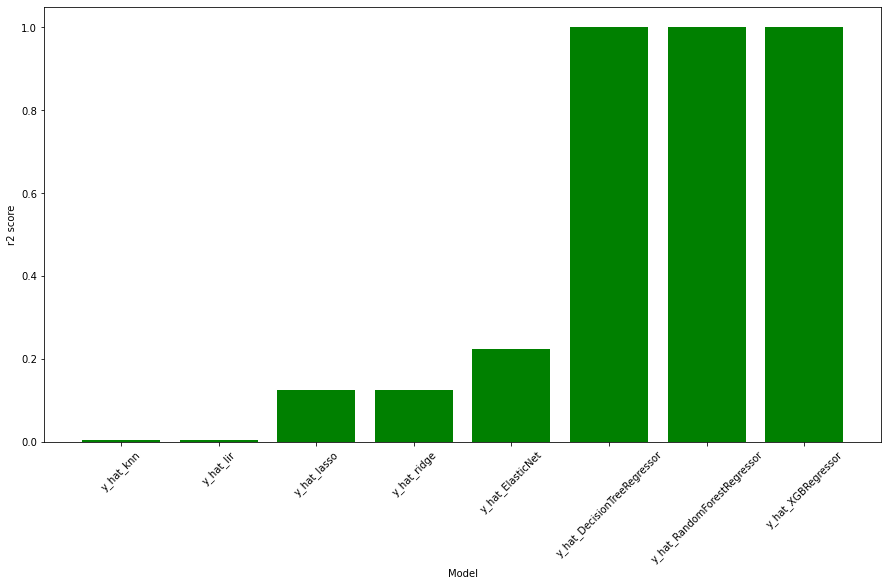

In [73]:
fig, ax = plt.subplots(figsize=(15,8))
plt.bar(df_results.columns, sorted(df_results.T[0]), color="green")
plt.ylabel("r2 score")
plt.xlabel("Model")
plt.xticks(rotation=45);
plt.show()

In [76]:
def gs_best(params, model, model_name):
    model2 = model()
    gs = GridSearchCV(model2, params, cv=5, n_jobs=-1, verbose=1)    
    gs.fit(X_train, y_train)
    best = model(**gs.best_params_).fit(X_train, y_train)
    y_hat=best.predict(X_test)
    r2=r2_score(y_test, y_hat)
    return model_name, r2

In [79]:
models = [DecisionTreeRegressor,
          RandomForestRegressor,
          XGBRegressor]
params = [{},
          {},
          {'max_depth':[3],'learning_rate':[0.05],'eta':np.logspace(0,1)}
         ]
names = ["DecisionTreeRegressor",
          "RandomForestRegressor",
          "XGBRegressor"]

for model, param, name in zip(models, params, names):
    (model_result, r2_result) = gs_best(param, model, name)    
    print(name," ",r2_result)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
DecisionTreeRegressor   1.0
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [96]:
def gs_best1(params, model, model_name):
    model2 = model()
    gs = GridSearchCV(model2, params, cv=5, n_jobs=-1, verbose=1)    
    gs.fit(X_train, y_train)
    best = model(**gs.best_params_).fit(X_train, y_train)
    y_hat=best.predict(X_test)
    r2=r2_score(y_test, y_hat)
    return best, r2

In [97]:
rfr_params = {}
(model_rfr, r2_rfr) = gs_best1(rfr_params, RandomForestRegressor, "RandomForestRegressor")
r2_rfr

Fitting 5 folds for each of 1 candidates, totalling 5 fits


1.0

In [88]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [100]:
model_rfr.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.99250461, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00373749, 0.0037579 , 0.        ,
       0.        , 0.        , 0.        ])

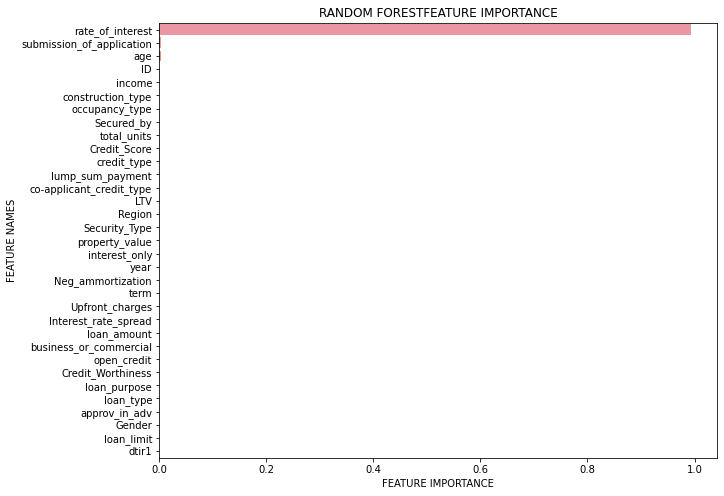

In [102]:
plot_feature_importance(model_rfr.feature_importances_,X_train.columns,'RANDOM FOREST')